In [98]:
%pylab inline
plt.style.use('seaborn-talk')

Populating the interactive namespace from numpy and matplotlib


In [0]:
%tensorflow_version 2.x

We will use this function to plot the metrics of our training process, to help in choosing the best model

In [0]:
def plot_metric(history, metric):
    history_dict = history.history
    values = history_dict[metric]
    if 'val_' + metric in history_dict.keys():  
        val_values = history_dict['val_' + metric]

    epochs = range(1, len(values) + 1)

    if 'val_' + metric in history_dict.keys():  
        plt.plot(epochs, val_values, label='Validation')
    plt.semilogy(epochs, values, label='Training')

    if 'val_' + metric in history_dict.keys():  
        plt.title('Training and validation %s' % metric)
    else:
        plt.title('Training %s' % metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid()

    plt.show()  

We will use this function to explore the data

In [0]:
def plot_mnist_image(N, imgs, labels):
  print("The image below should show the number %d" % labels[N])
  plt.imshow(imgs[N,], cmap=plt.cm.binary)
  plt.grid(True)

# The problem

We will recognize handwritten digits. For an image containing a number between 0 and 9, we will recognize the number and will produce an int as output

In [0]:
from keras.datasets import mnist

In [0]:
# Run this to download the data prior to the lecture
train_orig_data, test_orig_data = mnist.load_data()

In [104]:
# Aquí tenemos los datos (X)
train_orig_data[0].shape

(60000, 28, 28)

Tiene 60.000 imágenes de 28x28

In [105]:
# Aquí tenemos las etiquetas (y)
train_orig_data[1].shape

(60000,)

The image below should show the number 4


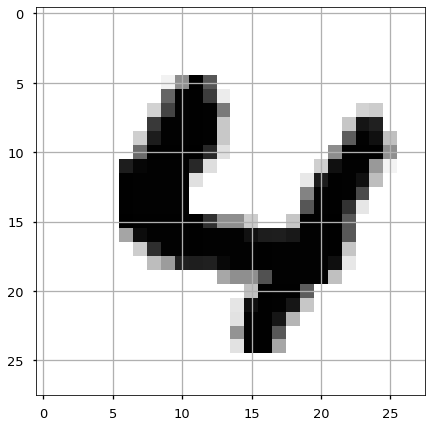

In [106]:
idx=np.random.randint(low=0,high=train_orig_data[0].shape[0],size=1)[0]
plot_mnist_image(idx, train_orig_data[0], train_orig_data[1])

In [0]:
train_imgs=train_orig_data[0]
train_labels=train_orig_data[1]

test_imgs=test_orig_data[0]
test_labels=test_orig_data[1]

The image below should show the number 1


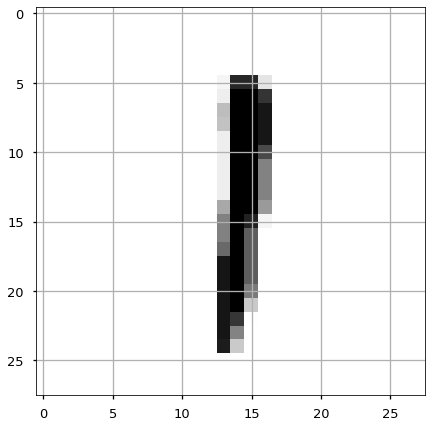

In [108]:
idx=np.random.randint(low=0,high=test_orig_data[0].shape[0],size=1)[0]
plot_mnist_image(idx, test_orig_data[0], test_orig_data[1])

We will design a network that will be able to recognize that the image is showing the number 7 (for all the images in the test set)

## Data transform

We need to change the shape of the data, so it can be fed to the network more easily

In [109]:
train_imgs.max(),train_imgs.min(),test_imgs.max(),test_imgs.min()

(255, 0, 255, 0)

In [110]:
train_imgs_n=train_imgs/255.0  #Normalizamos, pero aquí es más fácil porque min=0
test_imgs_n=test_imgs/255.0
train_imgs_n.max(),train_imgs_n.min(),test_imgs_n.max(),test_imgs_n.min()

(1.0, 0.0, 1.0, 0.0)

All the images are 28x28 matrices, with values between 0 and 255. Let's normalize the images, to avoid problems in the numerical computations using large numbers.

We will convert the matrix to a vector with 28x28 components, stacking columns on top of each other. This will make the design of the network.
* Alternatively, we could add a `Flatten(input_shape=(28,28))` layer to the model

La entrada de una capa densa es un vector: y= f(W*x+b)

In [111]:
train_imgs[0].shape

(28, 28)

Because we want to assign a *category* to each image, we need to transform the output to categorical format

In [112]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

Initially, our target data is just a set of numbers

In [113]:
train_labels.shape

(60000,)

We are going to transform it to **1-HOT encoding format**

One-hot encoding de 3 clases (0,1,2):

1 -> [0,1,0]

0 -> [1,0,0]

2 -> [0,0,1]

Para nuestro caso tenemos 10 categorías (del 0 al 9):

4 -> [0,0,0,0,1,0,0,0,0,0]

Queremos que nuestro predictor nos dé la mayor probabilidad en la posición de ese número

In [0]:
from tensorflow.keras.utils import to_categorical

We have to repeat the same process with the test data

In [115]:
to_categorical(9,num_classes=10)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [0]:
train_labels_1hot=to_categorical(train_labels,num_classes=10)
test_labels_1hot=to_categorical(test_labels,num_classes=10)

In [117]:
train_labels_1hot.shape, test_labels_1hot.shape

((60000, 10), (10000, 10))

## Let's build the model

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

In [0]:
def build_model():
  #Creamos el modelo
  m = Sequential()
  #Aplanamos las imágenes
  m.add(Flatten(input_shape=(28,28)))
  #Definimos las capas ocultas
  m.add((Dense(units=128,activation='relu')))
  m.add((Dense(units=64,activation='relu')))
  m.add((Dense(units=32,activation='relu')))
  #Definimos la capa de salida. Esta activación nos permite obtener la probabilidad
  #Tenemos que darle la salida del 1-hot
  m.add((Dense(units=10,activation='softmax')))
  m.summary()  

  return m

In [69]:
m=build_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 111,146
Trainable params: 111,146
Non-trainable params: 0
_________________________________________________________________


Contamos parámetros:

y = f*(W*x+b)

[y]=128, [W]=128x784, [x]=784, [b] = 128

In [0]:
from tensorflow.keras import optimizers

In [71]:
# Buscamos optimizadores
optimizers.Adam(learning_rate=5e-4)
optimizers.RMSprop(learning_rate=1e-3)

In [0]:
# De losses cogeríamos 'categorical_crossentropy'
from tensorflow.keras import losses

Ejemplo de crossentropy para dos clases:

 -label_c1 * log (predic_c1) + -label_c2 * log(predic_c2)

 Supongamos que me viene una imagen de clase 1:

 - label_c1=1, label_c2=0

- loss = -log(predic_c1)

por lo que loss tiene que valer 0 para minimizar el loss, por lo que la predic_c1 tiene que ser 1

Como usamos probabilidades:

prediction_c2=1-prediction_c1=0

In [0]:
# De la metrics cogeríamos 'categorical_accuracy'
from tensorflow.keras import metrics

Here we will make some decisions about how to train our model.

The **objective function**, called **loss function** in Deep Learning, will be *categorical crossentropy*. This is because we are trying to predict discrete classes. If we choose a different function, the solution will be different. This is the function that will tell us when we have found the *solution*. Different functions will point to different *solutions*.

The **optimizer** is the method that we will use to find the minimum of the **loss function**. In general, we will not find the global minimum of the loss function, but a minimum that is good enough. *RMSProp* is one the variants of gradient descent. But there are many more:
 - http://ruder.io/optimizing-gradient-descent/
 
These two settings will define what solution we will find during the training process.

The other parameter, the **metrics**, is only for information purposes. In each step of the training (called **epoch**), Keras will report the value of the metrics. But whether we choose one metric or another will not influence the training process. It is only for reporting how the training is going. That information will be useful for the validation of the model, that is, for the **hyperparameters tuning**.


Now let's fit the neural network. We will keep the results in a *history* object to plot some parameters after the training, and use that information for improving our model (changing layers, activation functions, etc). This process is called **hyperparameters tuning** or hypeparameters search.

Here we need to set two parameters: the number of **epochs** and the **batch size**.

In previous cells, I have said that the training process is an optimization problem: we try to find the minimum.

That's actually not entirely true. In practice, we don't keep searching for a minimum. Instead, we train for a preset number of epochs. Then we analyze the output using the validation set. If we detect overfit, then we reduce the number of epochs. If we don't detect it, then maybe we can keep going for some more epochs to find a better model. The number of epochs is another hyperparameter. In general, we should stop the training as early as possible. Any further epoch can make our model overfit, and therefore generalize poorly.

The batch size is another hyperparameter. The network is not updated item by item, vector by vector. We can actually calculate the weights for a batch of several items, forming a matrix or a tensor. The batch size will affect the granularity of the calculations and the performance. A larger batch size will probably result in a slightly worse accuracy, but in a better performance. As long as the batch size is not so huge that it cannot be kept in memory. Because we are running on a GPU, it is a good idea to use a power of 2 for the batch size. It will probably make a better use of the GPU. But again, the effect of the batch size must be tested using the validation set, and adjusted until we find a good value for that parameter.

An epoch is a full pass over the training dataset. At the end of each epoch, Keras will calculate the value of the metrics for the training set, and the loss function and metrics for the validation set. The loss and metrics of the validation set are useful for the hyperparameters tuning process.



In [0]:
#Compilamos el modelo
m.compile(optimizer=optimizers.Adam(learning_rate=0.001),loss=losses.categorical_crossentropy,metrics=[metrics.categorical_accuracy])

Resumimos todo:

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

In [0]:
def build_model():
  #Creamos el modelo
  m = Sequential()
  #Aplanamos las imágenes
  m.add(layers.Flatten(input_shape=(28,28)))
  #Definimos las capas ocultas
  m.add(layers.Dense(units=1024,activation='softplus'))
  m.add(layers.Dense(units=512,activation='softplus'))
  m.add(layers.Dense(units=256,activation='softplus'))
  m.add(layers.Dense(units=128,activation='softplus'))
  m.add(layers.Dropout(rate=0.2))
  m.add(layers.Dense(units=64,activation='softplus'))
  m.add(layers.Dropout(rate=0.2))
  m.add(layers.Dense(units=32,activation='softplus'))
  #Definimos la capa de salida. Esta activación nos permite obtener la probabilidad
  #Tenemos que darle la salida del 1-hot
  m.add(layers.Dense(units=10,activation='softmax'))
  m.summary()  

  return m

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 1024)              803840    
_________________________________________________________________
dense_39 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_40 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_41 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 64)               

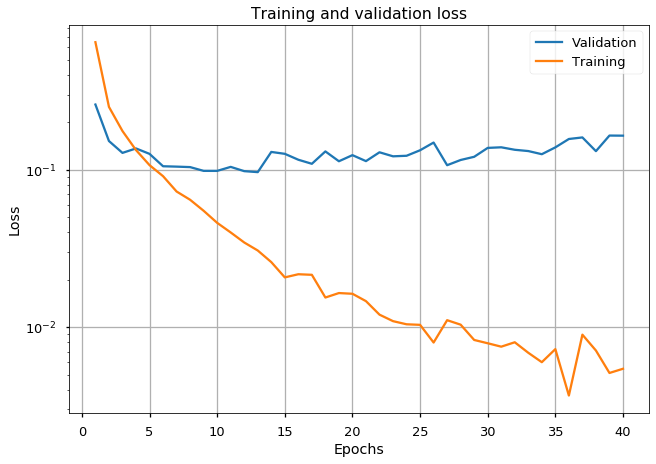

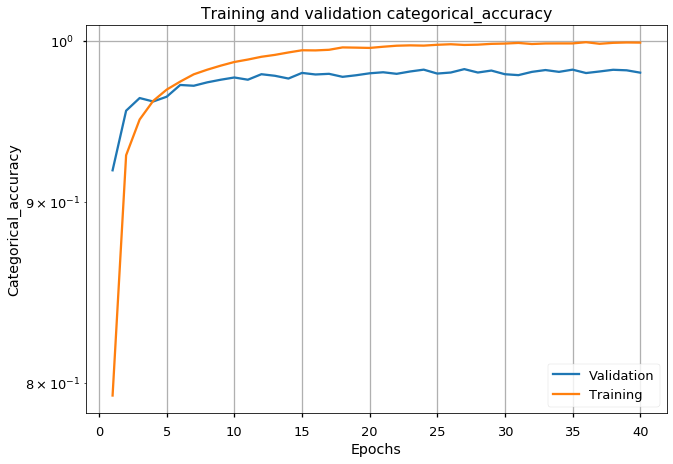

In [92]:
#Construimos el modelo
m=build_model()
#Compilamos el modelo
m.compile(optimizer=optimizers.Adam(learning_rate=0.0005),loss=losses.categorical_crossentropy,metrics=[metrics.categorical_accuracy])
#Entrenamos el modelo
h=m.fit(x=train_imgs_n,y=train_labels_1hot,batch_size=50,epochs=40,validation_split=0.2)
plot_metric(h,'loss')
plot_metric(h,'categorical_accuracy')

## Exercises

* **EXERCISE 1**: Chante the activation function in the model. How does it affect accuracy? What happens if you use linear activation function? What happens if we use the $\tanh$ function? Does it affect to overfitting?
 * https://keras.io/activations/
 
Here we see that the accuracy keeps increasing over epochs. An overfitted model would produce a decrease of the validation accuracy at some point. This means that we have found an optimal model. The validation loss is stuck at a minimum, but the accuracy is not affected by the extra epochs.

_**EXERCISE 2**_: How is the model accuracy (measured with the test set, see below) affected if we start over and fit for 40 epochs? And for 4? And for 400?

_**EXERCISE 4**_: What is the most simple model that you can get that achieves a similar validation performance (accuracy)? (the loss values are not comparable, different networks will have different ranges of values for the loss functions)

Now let's check how well the model works with the test dataset. Remember that we don't have used it at all during the training and tuning of the model.

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

In [0]:
def build_model():
  #Creamos el modelo
  m = Sequential()
  #Aplanamos las imágenes
  m.add(layers.Flatten(input_shape=(28,28)))
  #Definimos las capas ocultas
  m.add(layers.Dense(units=1024,activation='elu'))
  m.add(layers.Dense(units=512,activation='elu'))
  m.add(layers.Dense(units=256,activation='elu'))
  m.add(layers.Dense(units=128,activation='elu'))
  m.add(layers.Dropout(rate=0.2))
  m.add(layers.Dense(units=64,activation='elu'))
  m.add(layers.Dropout(rate=0.2))
  m.add(layers.Dense(units=32,activation='elu'))
  #Definimos la capa de salida. Esta activación nos permite obtener la probabilidad
  #Tenemos que darle la salida del 1-hot
  m.add(layers.Dense(units=10,activation='softmax'))
  m.summary()  

  return m

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 1024)              803840    
_________________________________________________________________
dense_60 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_61 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_62 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 64)              

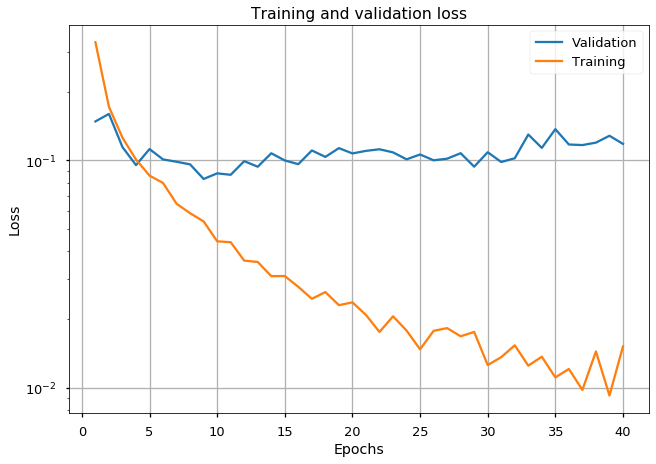

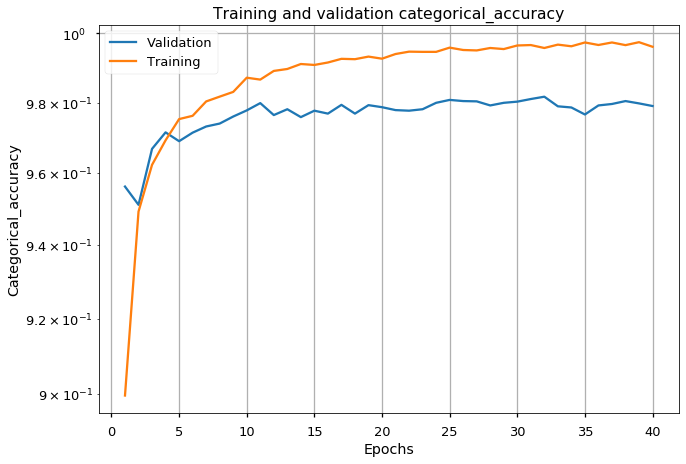

In [120]:
#Construimos el modelo
m=build_model()
#Compilamos el modelo
m.compile(optimizer=optimizers.Adam(learning_rate=0.0005),loss=losses.categorical_crossentropy,metrics=[metrics.categorical_accuracy])
#Entrenamos el modelo
h=m.fit(x=train_imgs_n,y=train_labels_1hot,batch_size=50,epochs=40,validation_split=0.2)
plot_metric(h,'loss')
plot_metric(h,'categorical_accuracy')

## Analyze the classification performance

In [121]:
m.evaluate(x=test_imgs_n, y=test_labels_1hot)

10000/10000 [==============================] - 1s 133us/sample - loss: 0.1111 - categorical_accuracy: 0.9793


[0.11113440472364346, 0.9793]

That's about a $98\%$ accuracy on the test set. Not bad.

With that accuracy, this is the number of images that are wrongly classified by our model:

In [122]:
loss, acc=m.evaluate(x=test_imgs_n, y=test_labels_1hot)

10000/10000 [==============================] - 1s 124us/sample - loss: 0.1111 - categorical_accuracy: 0.9793


In [123]:
n=test_labels_1hot.shape[0]
n*(1-acc)

206.9997787475586

Let's see how well it predicts some random items from the test set.

The image below should show the number 8


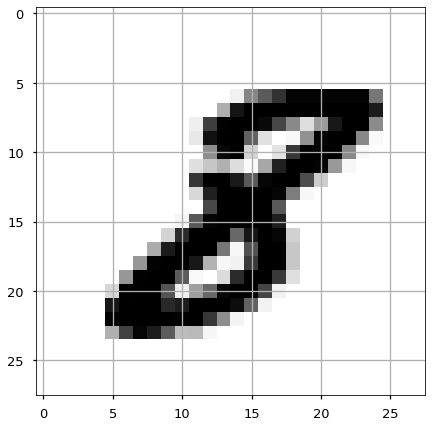

In [124]:
plot_mnist_image(2543, test_imgs, test_labels)

The prediction is a 10-element vector (*1-HOT encoded vector*), with the probability of each class. The location of the max is giving us the predicted class.

In [126]:
#El predict está pensado para una matriz de 3 dimensiones. De aquí obtenemos las probabilidades
pred=m.predict(np.reshape(test_imgs_n[2543],(1,28,28)))
pred

array([[3.5422488e-08, 2.0543298e-06, 5.9976571e-07, 4.6353991e-05,
        1.0312800e-06, 3.1198052e-08, 1.4926950e-06, 4.0230012e-07,
        9.9994576e-01, 2.2230997e-06]], dtype=float32)

In [127]:
# Como tenemos números podemos simplemente conocer la posición
np.argmax(pred)

8

In [129]:
pred=m.predict_classes(np.reshape(test_imgs_n[2543],(1,28,28)))
pred

array([8])

YES! Our model predicts 8

_**EXERCISE 5**_: Can you find a test item that is predicted wrongly? How many images are predicted wrongly? Can you find all the items that are wrongly classified? For instance, the test element with index 3943 is a 3 but we predict a 5


The image below should show the number 3


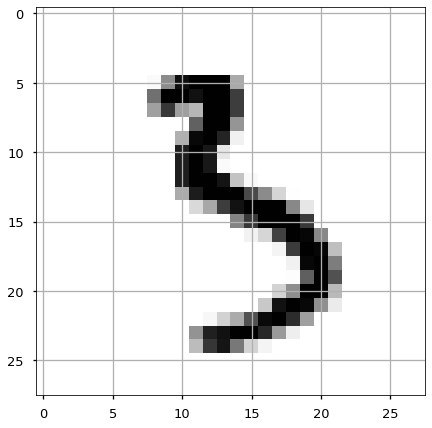

In [130]:
plot_mnist_image(3943, test_imgs, test_labels)

In [132]:
np.argmax(m.predict(test_imgs_n[3943:3944,]))

3

Ok, but in which positions can we find all the misclassifications?

In [136]:
#Podemos ver cuales están mal predichos
prediction=m.predict_classes(test_imgs_n)
mask=prediction==test_labels
wrong_predicted_mask=prediction!=test_labels
test_labels[wrong_predicted_mask].shape

(207,)

In [137]:
wrong_predicted=test_labels[wrong_predicted_mask]
wrong_predicted

array([9, 4, 4, 8, 7, 5, 5, 6, 8, 8, 1, 9, 8, 2, 5, 7, 7, 0, 7, 9, 8, 1,
       5, 5, 6, 7, 4, 7, 4, 6, 7, 9, 9, 5, 8, 7, 5, 5, 8, 7, 7, 7, 4, 2,
       9, 7, 2, 5, 2, 3, 7, 4, 2, 8, 0, 8, 9, 7, 9, 7, 7, 5, 7, 5, 4, 6,
       4, 1, 5, 9, 7, 5, 9, 2, 8, 5, 7, 6, 5, 9, 7, 3, 3, 5, 9, 3, 5, 8,
       1, 5, 5, 7, 8, 7, 2, 6, 7, 4, 9, 6, 5, 7, 8, 8, 7, 8, 2, 5, 7, 2,
       6, 8, 5, 1, 9, 4, 9, 9, 7, 7, 0, 8, 9, 2, 7, 2, 2, 9, 5, 5, 5, 9,
       7, 8, 6, 4, 8, 6, 2, 2, 3, 9, 8, 9, 0, 2, 7, 8, 1, 1, 7, 2, 7, 7,
       4, 3, 7, 4, 5, 3, 5, 3, 8, 5, 3, 9, 8, 2, 0, 0, 8, 1, 6, 0, 1, 5,
       5, 3, 3, 0, 7, 8, 4, 7, 7, 7, 1, 8, 2, 9, 9, 1, 9, 0, 9, 2, 6, 2,
       5, 4, 2, 5, 9, 2, 0, 6, 2], dtype=uint8)

_**EXERCISE 6**_: Some digits are more difficult to recognize than others. Because we know the test labels, we can find out how many times the corresponding test images are misclassified. Could you find what are the top 3 test labels that are more often misclassified?

Let's check some wrong predictions

The image below should show the number 8


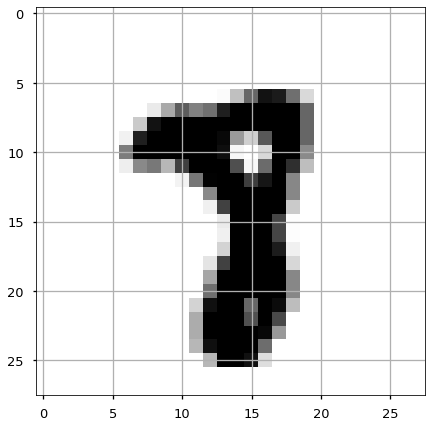

In [143]:
plot_mnist_image(4978, test_imgs, test_labels)

In [144]:
prediction[4978]

3

These are the items that are wrongly classified:

In [145]:
# Si queremos saber los indices de las imágenes mal clasificadas:
np.where(wrong_predicted_mask)

(array([ 104,  115,  247,  268,  337,  340,  412,  445,  495,  582,  619,
         630,  655,  659,  674,  684,  689,  717,  726,  813,  839,  900,
         951, 1003, 1014, 1039, 1112, 1156, 1178, 1182, 1226, 1232, 1247,
        1299, 1319, 1328, 1378, 1393, 1464, 1494, 1500, 1522, 1549, 1551,
        1553, 1566, 1609, 1670, 1678, 1681, 1721, 1751, 1790, 1813, 1843,
        1850, 1901, 1941, 1992, 2016, 2024, 2035, 2070, 2073, 2130, 2135,
        2145, 2182, 2291, 2293, 2325, 2369, 2387, 2488, 2512, 2597, 2607,
        2654, 2810, 2863, 2915, 2921, 2927, 2930, 2939, 2953, 2970, 3062,
        3073, 3115, 3117, 3225, 3289, 3333, 3375, 3422, 3451, 3490, 3503,
        3520, 3558, 3604, 3629, 3727, 3751, 3757, 3772, 3776, 3808, 3817,
        3853, 3871, 3893, 3906, 3926, 3941, 3985, 4000, 4007, 4027, 4065,
        4123, 4163, 4176, 4199, 4205, 4248, 4259, 4271, 4359, 4360, 4369,
        4433, 4497, 4536, 4567, 4671, 4699, 4713, 4723, 4740, 4761, 4807,
        4823, 4880, 4939, 4966, 4978, 

In [146]:
# Aquí podemos ver las etiquetas en las que fallamos
wrong_predicted=test_labels[wrong_predicted_mask]
wrong_predicted

array([9, 4, 4, 8, 7, 5, 5, 6, 8, 8, 1, 9, 8, 2, 5, 7, 7, 0, 7, 9, 8, 1,
       5, 5, 6, 7, 4, 7, 4, 6, 7, 9, 9, 5, 8, 7, 5, 5, 8, 7, 7, 7, 4, 2,
       9, 7, 2, 5, 2, 3, 7, 4, 2, 8, 0, 8, 9, 7, 9, 7, 7, 5, 7, 5, 4, 6,
       4, 1, 5, 9, 7, 5, 9, 2, 8, 5, 7, 6, 5, 9, 7, 3, 3, 5, 9, 3, 5, 8,
       1, 5, 5, 7, 8, 7, 2, 6, 7, 4, 9, 6, 5, 7, 8, 8, 7, 8, 2, 5, 7, 2,
       6, 8, 5, 1, 9, 4, 9, 9, 7, 7, 0, 8, 9, 2, 7, 2, 2, 9, 5, 5, 5, 9,
       7, 8, 6, 4, 8, 6, 2, 2, 3, 9, 8, 9, 0, 2, 7, 8, 1, 1, 7, 2, 7, 7,
       4, 3, 7, 4, 5, 3, 5, 3, 8, 5, 3, 9, 8, 2, 0, 0, 8, 1, 6, 0, 1, 5,
       5, 3, 3, 0, 7, 8, 4, 7, 7, 7, 1, 8, 2, 9, 9, 1, 9, 0, 9, 2, 6, 2,
       5, 4, 2, 5, 9, 2, 0, 6, 2], dtype=uint8)

In [147]:
# Podemos hacer una agrupación para ver cuales son los más fallados
np.bincount(wrong_predicted)

array([10, 11, 23, 11, 15, 32, 13, 39, 26, 27])

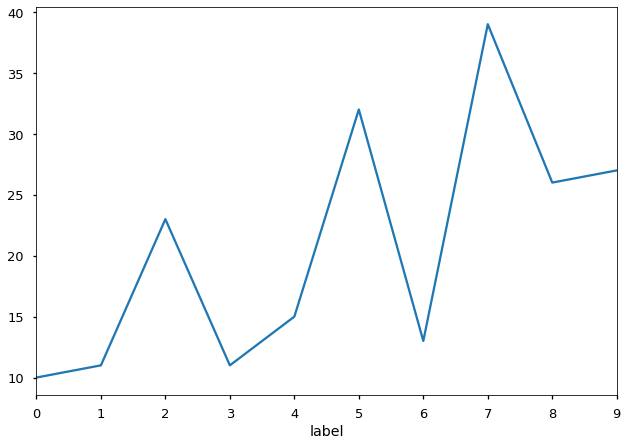

In [155]:
#Otra forma
import pandas as pd
df=pd.DataFrame({'label':wrong_predicted})
df.groupby('label')['label'].count().plot()

So we see that $7$ is wrongly classified more than the rest. But does it mean that our model has more difficulties recognizing 9s?